In [168]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix


from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoders, label_binarize

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

from scipy import interp
from itertools import cycle

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [15]:
tweets_df = pd.read_csv('./cleaned_tweets.csv')

### Data Preparation

In [18]:
tweets_df.head()

,final_cleaned_content,annotation.labels
0,pdhl poros ke ini sebenarnya mau nelikung...,joy
1,maap bosmending ngomong realita aja soal k...,joy
2,seandainya sekutu berpaling apa masih tetap...,fear
3,saya dukung pak prabowo capresnamun plihan,joy
4,mencari yang setia dan sepemikiran itu sulit...,trust


In [19]:
tweets_df['annotation.labels'].value_counts()

joy             1576
trust           1309
anticipation     873
anger            797
disgust          448
fear             423
sadness          405
surprise          70
other              6
Name: annotation.labels, dtype: int64

In [124]:
# Holding out 5 tweets from each label for prediction in the end. NOTE: We'll remove "other" category from the modelling.
labels = tweets_df['annotation.labels'].unique()
temp_df = []
for label in labels:
    if label == 'other':
        continue
    else:
        temp_df.append(tweets_df[tweets_df['annotation.labels'] == label].sample(frac=1).iloc[:5])


df_holdout = pd.concat(temp_df).reset_index()

In [125]:
train_set = tweets_df[~tweets_df['final_cleaned_content'].isin(df_holdout['final_cleaned_content'])]
train_set = train_set[train_set['annotation.labels'] != "other"]

In [126]:
# Label Encoding
le = LabelEncoder()
train_set['labels'] = le.fit_transform(train_set['annotation.labels'])

In [129]:
train_set.head()

,final_cleaned_content,annotation.labels,labels
0,pdhl poros ke ini sebenarnya mau nelikung...,joy,4
1,maap bosmending ngomong realita aja soal k...,joy,4
2,seandainya sekutu berpaling apa masih tetap...,fear,3
3,saya dukung pak prabowo capresnamun plihan,joy,4
4,mencari yang setia dan sepemikiran itu sulit...,trust,7


### Featurization

In [130]:
#Creating features using TF-IDF Vectorizer

tweets = train_set['final_cleaned_content'].astype(str)

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                   min_df = 2,
                                   max_df = 0.9)
#features
X = tfidf_vectorizer.fit_transform(tweets)

#target
y = train_set['labels'].values

print(X.shape)
print(y.shape)

(5861, 14086)
(5861,)


In [132]:
#Dimensionality Reduction

lsa = TruncatedSVD(n_components=500,
                   n_iter=10,
                   random_state=123)

X_ = lsa.fit_transform(X)
X_.shape

(5861, 500)

### Modelling

In [133]:
# Creating dictionary of various models

model_dict = {'Dummy': DummyClassifier(random_state=123),
              'KNN': KNeighborsClassifier(),
              'SGD': SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=123, max_iter=10, tol=None),
              'Random_Forest': RandomForestClassifier(random_state=123, n_estimators=100),
              'Decision_Tree': DecisionTreeClassifier(random_state=123),
              'AdaBoost': AdaBoostClassifier(random_state=123),
              'NB': GaussianNB(),
              'Linear_SVC': LinearSVC()
             }

# Train-Valid Split with stratified sampling
X_train, X_valid, y_train, y_valid = train_test_split(X_, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)


def get_model_scores(model_dict):
    model_name, acc_score, prec_score, rec_score, f1_score_ = [], [], [], [], []
    for name, model_obj in model_dict.items():
        model_name.append(name)
        model_obj.fit(X_train, y_train)
        pred = model_obj.predict(X_valid)
        acc_score.append(accuracy_score(y_valid, pred))
        prec_score.append(precision_score(y_valid, pred, average='macro'))
        rec_score.append(recall_score(y_valid, pred, average='macro'))
        f1_score_.append(f1_score(y_valid, pred, average='macro'))
        df = pd.DataFrame([model_name, acc_score, prec_score, rec_score, f1_score_]).T
        df.columns=['model_name',
                 'accuracy_score',
                 'precision_score',
                 'recall_score',
                 'f1_score'
                ]
        df = df.sort_values(by='f1_score', ascending=False)
    return df
    
get_model_scores(model_dict)

,model_name,accuracy_score,precision_score,recall_score,f1_score
7,Linear_SVC,0.43,0.46,0.33,0.35
2,SGD,0.42,0.31,0.31,0.29
6,NB,0.30,0.27,0.31,0.27
1,KNN,0.33,0.29,0.23,0.23
3,Random_Forest,0.35,0.31,0.21,0.19
4,Decision_Tree,0.25,0.18,0.18,0.18
5,AdaBoost,0.28,0.18,0.17,0.16
0,Dummy,0.20,0.14,0.14,0.14


### Hyperparameter Tuning

In [134]:
# Linear SVC
loss =  ['squared_hinge', 'hinge']
penalty = ['l2']
C = [1, 5, 100, 1000]
max_iter = [5, 1000, 10000]
random_state = [123]

clf = LinearSVC()

params = dict(loss=loss,
              penalty=penalty,
              C=C,
              max_iter=max_iter,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params,
                          cv = 5,
                          verbose = 1, 
                          n_jobs = -1)

linear_svc_best_model = gridsearch.fit(X_, y)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 17.9min finished


In [139]:
# Using the best model from the gridsearch, to predict and evaluate on the valid set.
y_pred = linear_svc_best_model.predict(X_valid)
f1_score(y_valid, y_pred, average='macro')

0.48240940223902107

In [142]:
linear_svc_best_model.best_estimator_

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=123, tol=0.0001,
     verbose=0)

### Model Evaluation

In [140]:
# AUC for best linear_svc model obtained through hyperparameter tuning

y_binarize = label_binarize(y, classes=np.unique(y))
nb_classes = y_binarize.shape[1]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_,
                                                            y_binarize,
                                                            test_size = .2,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 123)

# Model to predict each class against the other
linear_svc_ova = OneVsRestClassifier(linear_svc_best_model)

clf = linear_svc_ova.fit(X_train_b, y_train_b)



Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.4min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.0min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.3min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.7min finished


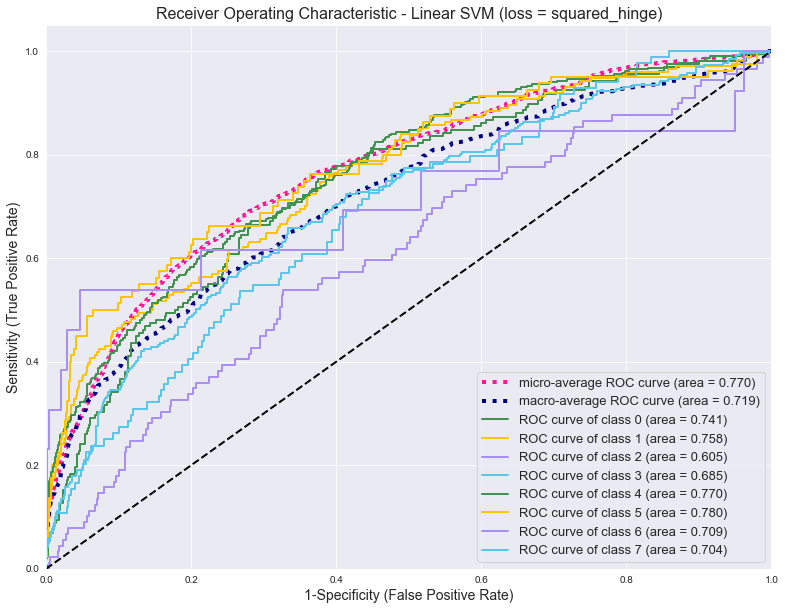

In [143]:
y_score = clf.decision_function(X_test_b)

# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(nb_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
mean_tpr /= nb_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(nb_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - Linear SVM (loss = squared_hinge)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

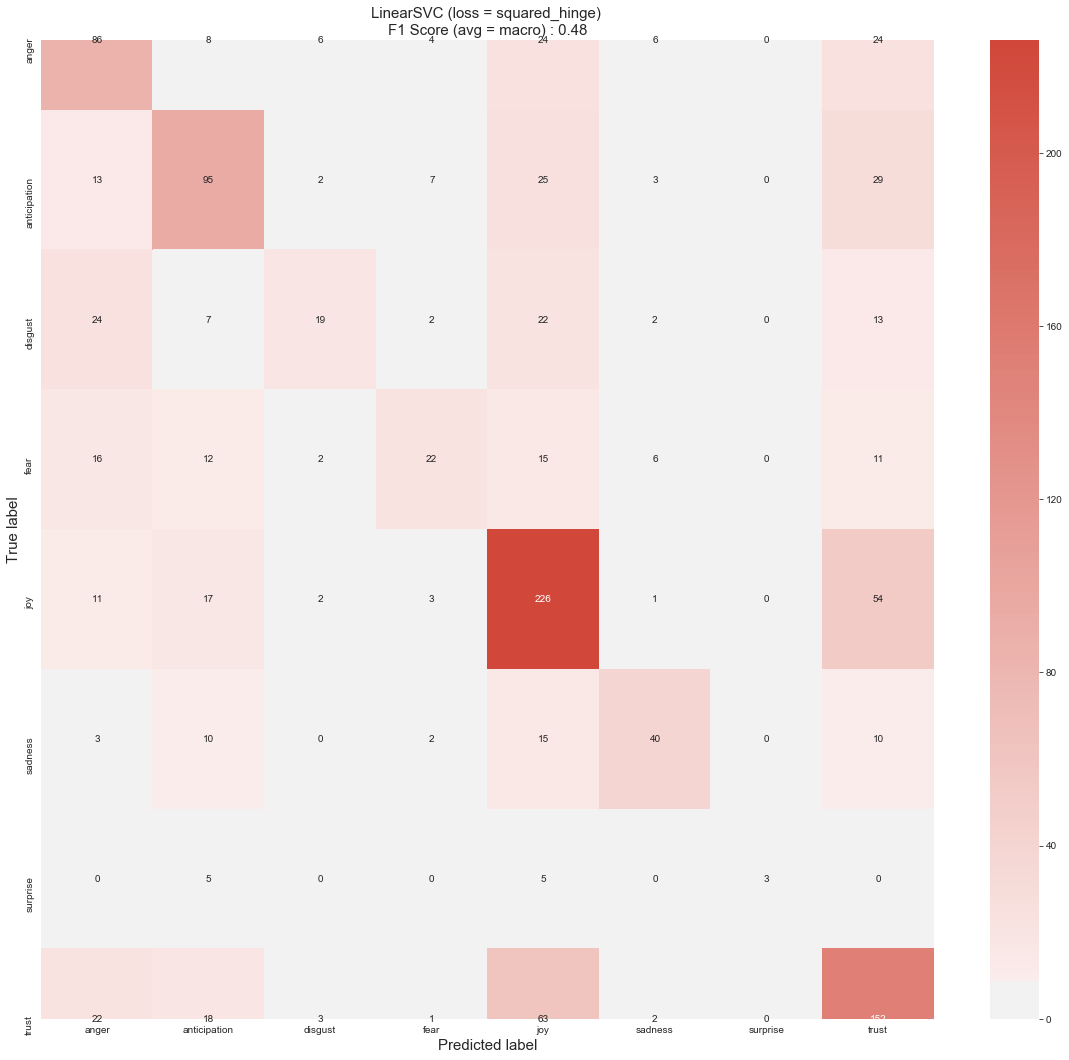

In [193]:
# Confusion Matrix - LinearSVC ( On previously created valid set)

cm = confusion_matrix(y_valid, y_pred)

cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

#Plot the heatmap
plt.figure(figsize=(20, 18))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('LinearSVC (loss = squared_hinge) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_valid, y_pred, average='macro')), fontsize = 15)
plt.ylabel('True label', fontsize = 15)
plt.xlabel('Predicted label', fontsize = 15)
plt.show()

In [152]:
# Prediction on the holdout test created before

holdout_set = df_holdout['final_cleaned_content'].astype('str')

X_holdout_tfidf = tfidf_vectorizer.transform(holdout_set)
X_holdout = lsa.transform(X_holdout_tfidf)

#Fitting on full data(train + valid set)
linear_svc_best_model.fit(X_, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 18.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['squared_hinge', 'hinge'], 'penalty': ['l2'], 'C': [1, 5, 100, 1000], 'max_iter': [5, 1000, 10000], 'random_state': [123]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [158]:
# Saving predictions on holdout set along with the correct in the dataframe
df_holdout['prediction'] = linear_svc_best_model.predict(X_holdout)
df_holdout['prediction'] = df_holdout['prediction'].apply(lambda x: le.inverse_transform([x])[0])

df_holdout[['final_cleaned_content', 'annotation.labels', 'prediction']]

,final_cleaned_content,annotation.labels,prediction
0,catatan dari materi pak menteri bahwa indones...,joy,trust
1,bersama prof mahfud md nketua umum ppp m romah...,joy,joy
2,live silaturahmi dng kh maghfur i amp pengur...,joy,joy
3,buka puasa jadi lebih nikmat dengan paket ber...,joy,joy
4,maju terus para penge,joy,trust
5,seharusnya yang perlu di pertanyakan itu j...,fear,trust
6,banyak yg bilang pemerintahan ini lumayan dar...,fear,trust
7,pengacara setya novanto kita diperkosa,fear,trust
8,jika menang pun kalah dimata allah nhebat do...,fear,trust
9,rusuh di debat publik pilgub jabar gara gara p...,fear,joy


### Fasttext embedding based classification

In [159]:
import fasttext

In [160]:
ft = fasttext.load_model('./cc.id.300.bin')

In [161]:
ft.get_dimension()

300

In [162]:
all_words = []

for _, row in tweets_df.iterrows():
    tweet = row['final_cleaned_content']
    tweet = tweet.split()
    all_words.extend(tweet)

all_words = list(set(all_words))

In [163]:
len(all_words)

18549

In [164]:
wv_dictionary = {w: ft.get_word_vector(w) for w in all_words}

In [165]:
import pickle
with open('./ft_wv.pickle', 'wb') as f_obj:
    pickle.dump(wv_dictionary, f_obj)

In [166]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, ft_wv):
        self.ft_wv = ft_wv
        if len(ft_wv) > 0:
            self.dim = ft_wv[next(iter(all_words))].shape[0]
        else:
            self.dim = 0
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array(
            [np.mean([self.ft_wv[w] for w in words if w in self.ft_wv] or [np.zeros(self.dim)], axis=0)
             for words in X
            ])

In [185]:
linearsvc_w2v = Pipeline([("ft_vectorizer", MeanEmbeddingVectorizer(wv_dictionary)),
                      ("linear_svc", LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [181]:
tweets_df = tweets_df[tweets_df['annotation.labels'] != 'other']
tweets_df['labels'] = tweets_df['annotation.labels'].apply(lambda x: le.transform([x])[0])

In [182]:
X = tweets_df['final_cleaned_content'].astype(str)
y = tweets_df['labels']

In [186]:
cv_score = cross_val_score(linearsvc_w2v, X, y, cv=5 , scoring='f1_macro')

In [190]:
cv_score.mean()

0.12944802609022166